In [1]:
#env:ml-s7
import numpy as np
import pandas as pd
# from icecream import ic
import subprocess
import json
import os
import plotly.graph_objects as go
from matplotlib import pyplot as plt
# import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely.ops import cascaded_union, unary_union
# from shapely import geometry
# from geopy import distance
%matplotlib inline
import plotly.express as px 
from scipy import signal
from tqdm import tqdm
# from Bio import Phylo
# import ete3
import itertools
import sklearn

In [2]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

# Data exploration the MIC

## New 2023 data also using new sample selection

### RIF

In [167]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_rif = df[df['RIF_MIC'].isin(['>4','4.0', '2.0', '1.0', '0.5', '0.25', '0.12','<=0.06'])]
for i, row in df_rif.iterrows():
    x = 'RIF_MIC'
    if row[x] == '>4' :
        df_rif.loc[i, f'{x}'] = '8'
    elif row[x] == '<=0.06':
        df_rif.loc[i, f'{x}'] = '0.03'

/tmp/ipykernel_114410/665846634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rif.loc[i, f'{x}'] = '0.03'
/tmp/ipykernel_114410/665846634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rif.loc[i, f'{x}'] = '8'


In [164]:
variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_rif
overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
variants = variants[variants['sample_id'].isin(overlap)]
variants['SNP'] = variants['gene'] + '-'+ variants['change']

def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
    # Create a dictionary from query_list and values_list for direct mapping
    query_dict = dict(zip(query_list, values_list))
    
    # Use list comprehension to build the output list directly
    output_list = [query_dict.get(snp, 0) for snp in set_list]
    
    return output_list

# Example usage
# set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
# query_list = ['SNP2', 'SNP4']
# values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
# output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
# print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

aa = []
all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
for x in tqdm(variants['sample_id'].unique()):
    aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
    # print('SNP')
aa_array = np.array(aa)
aa_array[aa_array < 0.8] = 0
aa_array[aa_array >= 0.8] = 1

0it [00:00, ?it/s]


In [19]:
mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
# mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
# mic_aa = mic_aa.sort_values('ENA_RUN')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

/tmp/ipykernel_114410/465165320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_114410/465165320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


In [103]:
np.savetxt('data_new_rif/aa_data_train.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_rif/aa_data_test.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')

np.savetxt('data_new_rif/aa_data_train.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_rif/aa_data_test.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')
mic_aa = mic_aa[['RIF_MIC']].astype('float')

mic_aa.iloc[:int(mic_aa.shape[0]*0.9),:].to_csv('data_new_rif/mic_aa_train.csv', index=False)
mic_aa.iloc[int(mic_aa.shape[0]*0.9):,:].to_csv('data_new_rif/mic_aa_test.csv', index=False)

# PCA

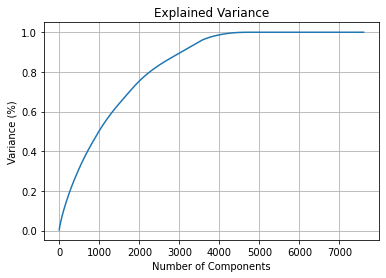

In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

X = aa_array  # Example data

# Step 1: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assuming X_scaled is your standardized 14954-dimensional data
pca = PCA().fit(X_scaled)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Assuming X is your data array where each row is a sample
X = aa_array  # Example data

# Step 1: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
# Let's say you want to reduce the dataset to 2 dimensions
pca = PCA(n_components=4000)
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X.shape)
print("Reduced shape:", X_pca.shape)


KeyboardInterrupt: 

In [70]:
np.savetxt('data_new_rif/aa_data_train_pca4k.csv', X_pca[:int(X_pca.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_rif/aa_data_test_pca4k.csv', X_pca[int(X_pca.shape[0]*0.9):, :], delimiter=',', fmt='%s')

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Assuming X is your data array where each row is a sample
X = aa_array  # Example data

# Step 1: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
# Let's say you want to reduce the dataset to 2 dimensions
pca = PCA(n_components=3000)
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X.shape)
print("Reduced shape:", X_pca.shape)

np.savetxt('data_new_rif/aa_data_train_pca3k.csv', X_pca[:int(X_pca.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_rif/aa_data_test_pca3k.csv', X_pca[int(X_pca.shape[0]*0.9):, :], delimiter=',', fmt='%s')

Original shape: (7605, 14954)
Reduced shape: (7605, 3000)


In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Assuming X is your data array where each row is a sample
X = aa_array  # Example data

# Step 1: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
# Let's say you want to reduce the dataset to 2 dimensions
pca = PCA(n_components=2000)
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X.shape)
print("Reduced shape:", X_pca.shape)

np.savetxt('data_new_rif/aa_data_train_pca2k.csv', X_pca[:int(X_pca.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_rif/aa_data_test_pca2k.csv', X_pca[int(X_pca.shape[0]*0.9):, :], delimiter=',', fmt='%s')

Original shape: (7605, 14954)
Reduced shape: (7605, 2000)


# Binary binning

In [ ]:
dict(mic_aa['RIF_MIC'].value_counts())

encoded_mic = []
for value in mic_aa['RIF_MIC']:
    if value < 0.5:
        encoded_mic.append(0)  # mic < 0.05
    else:
        encoded_mic.append(1)  # 0.05 <= mic < 0.12
        
mic_aa_cp = mic_aa.copy()
mic_aa_cp['RIF_MIC'] = encoded_mic
mic_aa_cp.iloc[:int(mic_aa_cp.shape[0]*0.9),:].to_csv('data_new_rif/mic_aa_train_bi.csv', index=False)
mic_aa_cp.iloc[int(mic_aa_cp.shape[0]*0.9):,:].to_csv('data_new_rif/mic_aa_test_bi.csv', index=False)

NameError: name 'mic_aa' is not defined

# high mid low binning

In [105]:
dict(mic_aa['RIF_MIC'].value_counts())

{0.03: 2273,
 8.0: 2182,
 0.12: 2087,
 0.25: 717,
 0.5: 185,
 4.0: 161,
 2.0: 149,
 1.0: 114}

In [12]:
import matplotlib.pyplot as plt

# Extract the values from the 'RIF_MIC' column
rif_mic_values = mic_aa['RIF_MIC'].values

# Plot the histogram
plt.hist(rif_mic_values)

# Add labels and title
plt.xlabel('RIF_MIC')
plt.ylabel('Frequency')
plt.title('Histogram of RIF_MIC')

# Display the plot
plt.show()


NameError: name 'mic_aa' is not defined

In [13]:
encoded_mic = []
for value in mic_aa['RIF_MIC'].values.astype(float):
    if value <= 0.2:
        encoded_mic.append(0)  # mic < 0.05
    elif 0.2 <= value < 0.5:
        encoded_mic.append(1)  # 0.05 <= mic < 0.12
    elif 0.5 <= value < 8:
        encoded_mic.append(2)  # 0.12 <= mic < 0.25
    elif value >= 8:
        encoded_mic.append(3)  # mic >= 8
    else:
        # print(value)
        encoded_mic.append(np.nan)
        
        
# encoded_mic = []
# for value in mic_aa['RIF_MIC'].values.astype(float):
#     if value <= 0.2:
#         encoded_mic.append(0)  # mic < 0.05
#     elif 0.2 <= value < 0.5:
#         encoded_mic.append(1)  # 0.05 <= mic < 0.12
#     elif 0.5 <= value < 8:
#         encoded_mic.append(2)  # 0.12 <= mic < 0.25
#     elif value >= 8:
#         encoded_mic.append(3)  # mic >= 8
#     else:
#         # print(value)
#         encoded_mic.append(np.nan)

NameError: name 'mic_aa' is not defined

In [14]:
mic_aa_cp = mic_aa.copy()
mic_aa_cp['RIF_MIC'] = encoded_mic
mic_aa_cp.iloc[:int(mic_aa_cp.shape[0]*0.9),:].to_csv('data_new_rif/mic_aa_train_hml.csv', index=False)
mic_aa_cp.iloc[int(mic_aa_cp.shape[0]*0.9):,:].to_csv('data_new_rif/mic_aa_test_hml.csv', index=False)

NameError: name 'mic_aa' is not defined

In [15]:
encoded_mic = []
for value in mic_aa['RIF_MIC'].values.astype(float):
    if value <= 0.2:
        encoded_mic.append(0)  # mic < 0.05
    elif 0.25 <= value <= 0.5:
        encoded_mic.append(1)  # 0.05 <= mic < 0.12
    elif value >= 0.5:
        encoded_mic.append(2)  # mic >= 8
    else:
        # print(value)
        encoded_mic.append(np.nan)

NameError: name 'mic_aa' is not defined

In [108]:
mic_aa_cp = mic_aa.copy()
mic_aa_cp['RIF_MIC'] = encoded_mic
mic_aa_cp.iloc[:int(mic_aa_cp.shape[0]*0.9),:].to_csv('data_new_rif/mic_aa_train_hml3.csv', index=False)
mic_aa_cp.iloc[int(mic_aa_cp.shape[0]*0.9):,:].to_csv('data_new_rif/mic_aa_test_hml3.csv', index=False)

## sequence data

In [16]:
df_seq= pd.read_csv('data1/gene_seq.csv')


In [17]:
df_seq = df_seq[df_seq['wgs_id'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
# df_seq['wgs_id'] = pd.Categorical(df_seq['wgs_id'], categories=variants['sample_id'].unique().tolist(), ordered=True)
# df_seq = df_seq.sort_values('wgs_id')
df_seq.wgs_id = df_seq.wgs_id.astype('category')
df_seq.wgs_id = df_seq.wgs_id.cat.set_categories(variants['sample_id'].unique().tolist())
df_seq = df_seq.sort_values(["wgs_id"])  ## 'sort' changed to 'sort_values'

df_seq.iloc[:int(df_seq.shape[0]*0.9),:].to_csv('data_new_rif/gene_seq_train.csv', index=False)
df_seq.iloc[int(df_seq.shape[0]*0.9):,:].to_csv('data_new_rif/gene_seq_test.csv', index=False)

NameError: name 'variants' is not defined

In [100]:
mic_aa = cryptic[cryptic['ENA_RUN'].isin(df_seq['wgs_id'].unique())]#.iloc[:,14:27]
# mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
# mic_aa = mic_aa.sort_values('ENA_RUN')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(df_seq['wgs_id'].unique().tolist())
mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

mic_aa.iloc[:int(mic_aa.shape[0]*0.9),:].to_csv('data_new_rif/mic_seq_train.csv', index=False)
mic_aa.iloc[int(mic_aa.shape[0]*0.9):,:].to_csv('data_new_rif/mic_seq_test.csv', index=False)

/tmp/ipykernel_12566/1637526391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_12566/1637526391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(df_seq['wgs_id'].unique().tolist())


## EMB

Susceptible Conc.	| Intermediate Conc. | 	Resistant Conc.

<=2	|  4	| >=8

In [274]:
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 

In [171]:
df_emb['EMB_MIC']

0        1.0
1        1.0
2        2.0
3        1.0
4        2.0
        ... 
12281    2.0
12282    2.0
12283    1.0
12285    2.0
12286    2.0
Name: EMB_MIC, Length: 11762, dtype: float64

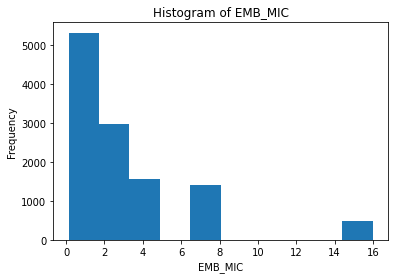

In [172]:
import matplotlib.pyplot as plt

# Extract the values from the 'RIF_MIC' column
emb_mic_values = df_emb['EMB_MIC'].values

# Plot the histogram
plt.hist(emb_mic_values)

# Add labels and title
plt.xlabel('EMB_MIC')
plt.ylabel('Frequency')
plt.title('Histogram of EMB_MIC')

# Display the plot
plt.show()

In [158]:
df_emb

,ENA_RUN,UNIQUEID,AMI_BINARY_PHENOTYPE,BDQ_BINARY_PHENOTYPE,CFZ_BINARY_PHENOTYPE,DLM_BINARY_PHENOTYPE,EMB_BINARY_PHENOTYPE,ETH_BINARY_PHENOTYPE,INH_BINARY_PHENOTYPE,KAN_BINARY_PHENOTYPE,...,INH_PHENOTYPE_QUALITY,KAN_PHENOTYPE_QUALITY,LEV_PHENOTYPE_QUALITY,LZD_PHENOTYPE_QUALITY,MXF_PHENOTYPE_QUALITY,RIF_PHENOTYPE_QUALITY,RFB_PHENOTYPE_QUALITY,ENA_SAMPLE,VCF,REGENOTYPED_VCF
0,ERR4810489,site.02.subj.0001.lab.2014222001.iso.1,S,NaN,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298516,00/01/08/61/10861/site.02.iso.1.subject.0001.l...,00/01/08/61/10861/site.02.iso.1.subject.0001.l...
1,ERR4810491,site.02.subj.0002.lab.2014222005.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,LOW,HIGH,HIGH,ERS5298518,00/01/08/63/10863/site.02.iso.1.subject.0002.l...,00/01/08/63/10863/site.02.iso.1.subject.0002.l...
2,ERR4810493,site.02.subj.0004.lab.2014222010.iso.1,S,S,S,NaN,S,I,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298520,00/01/08/67/10867/site.02.iso.1.subject.0004.l...,00/01/08/67/10867/site.02.iso.1.subject.0004.l...
3,ERR4810494,site.02.subj.0005.lab.2014222011.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298521,00/01/08/68/10868/site.02.iso.1.subject.0005.l...,00/01/08/68/10868/site.02.iso.1.subject.0005.l...
4,ERR4810495,site.02.subj.0006.lab.2014222013.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298522,00/01/08/69/10869/site.02.iso.1.subject.0006.l...,00/01/08/69/10869/site.02.iso.1.subject.0006.l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12281,ERR8699805,site.20.subj.SCH8601357.lab.YA00134970.iso.1,S,S,S,S,S,I,R,S,...,HIGH,HIGH,LOW,LOW,LOW,HIGH,HIGH,ERS6421705,00/02/91/38/29138/site.20.iso.1.subject.SCH860...,00/02/91/38/29138/site.20.iso.1.subject.SCH860...
12282,ERR8699231,site.20.subj.SCH8604398.lab.YA00134621.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,LOW,HIGH,LOW,HIGH,HIGH,ERS6421619,00/02/83/85/28385/site.20.iso.1.subject.SCH860...,00/02/83/85/28385/site.20.iso.1.subject.SCH860...
12283,ERR8699764,site.20.subj.SCH8604399.lab.YA00134971.iso.1,S,S,S,S,S,S,S,S,...,HIGH,LOW,HIGH,HIGH,LOW,LOW,HIGH,ERS6421664,00/02/84/35/28435/site.20.iso.1.subject.SCH860...,00/02/84/35/28435/site.20.iso.1.subject.SCH860...
12285,ERR8699232,site.20.subj.SCH8608295.lab.YA00134623.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,LOW,HIGH,LOW,HIGH,HIGH,ERS6421620,00/02/83/86/28386/site.20.iso.1.subject.SCH860...,00/02/83/86/28386/site.20.iso.1.subject.SCH860...


In [35]:
variants = pd.read_csv('variants_full.csv')
variants.shape

(7420996, 9)

### Testing the MIC for new threshold

In [3]:
# test = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/CRyPTIC_reuse_table_20221019_cleaned.csv')
# test['RIF_MIC'] = np.where(test['RIF_MIC'] == '>4', 8, test['RIF_MIC'])
# test['RIF_MIC'] = test['RIF_MIC'].dropna().astype(float)
# test['RFB_MIC'] = test['RFB_MIC'].dropna().astype(float)

# # variants[~variants['drugs'].isna()]

df_emb = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/CRyPTIC_reuse_table_20221019_cleaned.csv')
df_emb['RIF_MIC'] = np.where(df_emb['RIF_MIC'] == '>4', 8, df_emb['RIF_MIC'])
df_emb['RIF_MIC'] = df_emb['RIF_MIC'].dropna().astype(float)
df_emb['RFB_MIC'] = df_emb['RFB_MIC'].dropna().astype(float)

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

emb_val = variants[variants['drugs']=='ethambutol']

NameError: name 'variants' is not defined

In [162]:
df_emb['EMB_MIC'].value_counts()

EMB_MIC
1.00     3008
2.00     1847
4.00     1163
8.00     1083
0.50      933
35.00     471
16.00     180
0.25       63
32.00      57
0.05       48
0.12        5
Name: count, dtype: int64

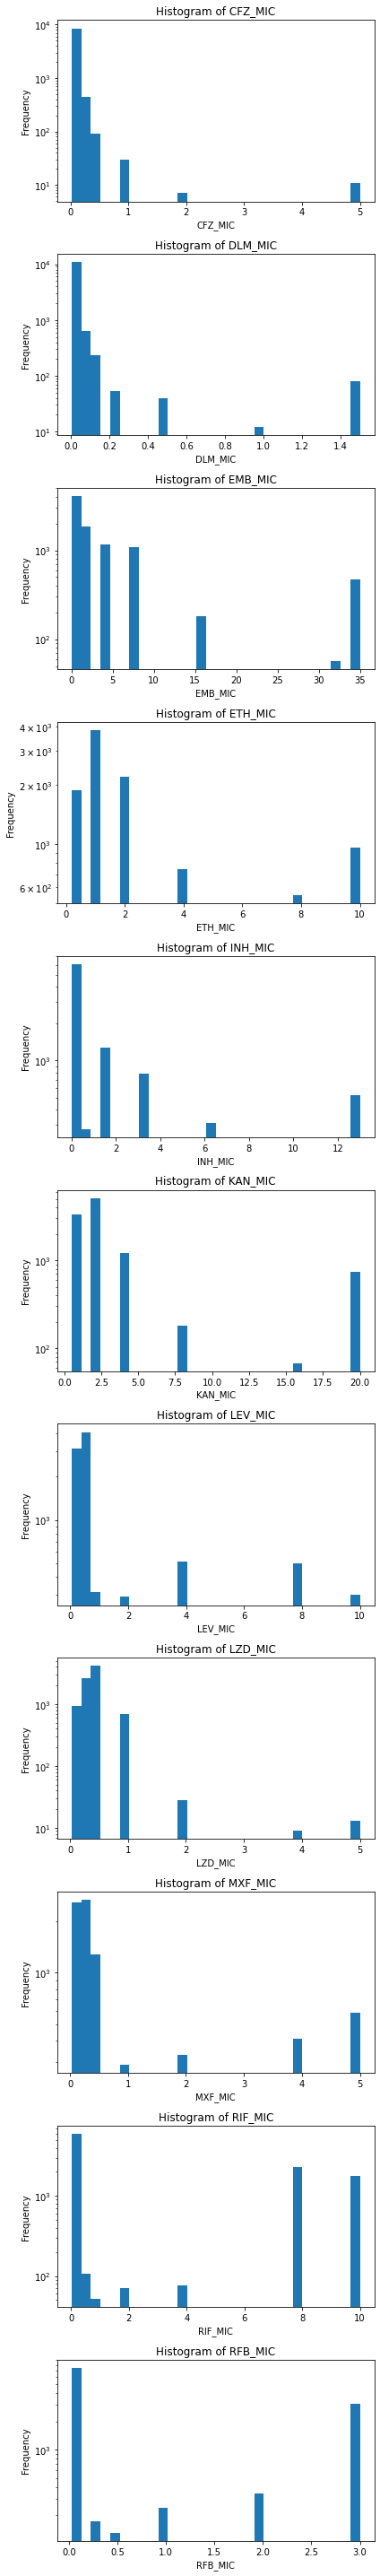

<Figure size 432x288 with 0 Axes>

In [161]:
import matplotlib.pyplot as plt

# List of columns to plot
columns = ['CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC', 
           'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']

# Define the bin width
bin_width = 0.5  # Adjust the bin width as needed

# Create subplots
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(6, 40))

for ax, col in zip(axes, columns):
    # Extract the values from the current column
    values = df_emb[col].values

    # Plot the histogram with specified bin size and log scale on y-axis
    ax.hist(values, bins=30, log=True)

    # Add labels and title
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {col}')

plt.subplots_adjust(hspace=0.5)  # Increase the hspace value as needed

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('plot.png')


In [183]:
mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]

mic_aa['EMB_MIC'].value_counts()

EMB_MIC
1.000     3941
2.000     2935
4.000     1492
8.000     1366
0.500     1115
16.000     461
0.250       91
0.125       44
Name: count, dtype: int64

In [234]:
# mic_aa = mic_aa_ori[~mic_aa_ori['EMB_PHENOTYPE_QUALITY'].isin(['LOW'])]
mic_aa = mic_aa_ori

In [5]:
discordance = []
discordance_values = []
_4_with_resistance = 0
_4_without_resistance = 0
to_be_dropped = []
for i, row in tqdm(mic_aa.iterrows()):
    x = 'EMB_MIC'
    # print(row[x])
    if row[x] <= 16 :
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('<4', row['ENA_RUN'], row[x])
            # discordance.append(row['ENA_RUN'])
            discordance_values.append(row[x])            
    if row[x] ==0.25 or row[x] ==0.125  :
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('=4', row['ENA_RUN'], row[x])
            _4_with_resistance += 1
            to_be_dropped.append(row['ENA_RUN'])
        else:
            _4_without_resistance += 1
    # elif pd.isna(row[x]):
    #     if row['ENA_RUN'] in emb_val['sample_id'].to_list():
    #         print('NaN', row['ENA_RUN'], row[x])  
    else:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('>4', row['ENA_RUN'], row[x])
            pass
print(_4_with_resistance, '/', _4_without_resistance+ _4_with_resistance)

NameError: name 'mic_aa' is not defined

In [229]:
mic_count = mic_aa['EMB_MIC'].value_counts().to_dict()
discordance_count = value_counts_list(discordance_values)

In [231]:
for x in discordance_count.keys():
    # print(x, discordance_count[x], mic_count[x], round(discordance_count[x]/mic_count[x],2))
    print(x,"|", round(discordance_count[x]/mic_count[x],2))

8.0 | 0.95
4.0 | 0.8
16.0 | 0.94
2.0 | 0.13
1.0 | 0.03
0.5 | 0.06
0.25 | 0.16
0.125 | 0.2


### Testing the MIC for new threshold finished

In [4]:
variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
# variants = variants[variants['drugs'].isin(['ethambutol'])]
variants = variants[variants['gene'].isin(['embB', 'embA', 'embC'])]
variants = variants[variants['sample_id'].isin(overlap)]
variants['SNP'] = variants['gene'] + '-'+ variants['change']

def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
    # Create a dictionary from query_list and values_list for direct mapping
    query_dict = dict(zip(query_list, values_list))
    
    # Use list comprehension to build the output list directly
    output_list = [query_dict.get(snp, 0) for snp in set_list]
    
    return output_list

# Example usage
# set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
# query_list = ['SNP2', 'SNP4']
# values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
# output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
# print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

aa = []
all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
for x in tqdm(variants['sample_id'].unique()):
    aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
    # print('SNP')
    
aa_array = np.array(aa)
aa_array[aa_array < 0.8] = 0
aa_array[aa_array >= 0.8] = 1

mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
# mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
# mic_aa = mic_aa.sort_values('ENA_RUN')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

### Testing the effect of quality on model performance

In [ ]:
# train_data = aa_array[:int(aa_array.shape[0]*0.9), :]
# test_data = aa_array[int(aa_array.shape[0]*0.9):, :]
# encoded_mic = np.array()
# for value in mic_aa['EMB_MIC'].to_list():
#     if value <4 :
#         encoded_mic.append(0)  # mic < 0.05
#     else:
#         encoded_mic.append(1)
# train_target = encoded_mic[:int(len(encoded_mic)*0.9)]
# test_target = encoded_mic[int(len(encoded_mic)*0.9):]

In [280]:
encoded_mic.shape

(11421,)

In [277]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score


# Assuming aa_array is a numpy array and mic_aa['EMB_MIC'] is a pandas Series

# Encode the target variable
encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

# Perform stratified train-test split
train_data, test_data, train_target, test_target = train_test_split(
    aa_array,
    encoded_mic,
    test_size=0.1,  # 10% for testing
    stratify=encoded_mic,  # Ensures the proportion of each class is preserved
    random_state=42  # For reproducibility
)

# The train_data and test_data now have the same proportion of target values as the original data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Train target distribution:", np.bincount(train_target))
print("Test target distribution:", np.bincount(test_target))


Train data shape: (10278, 1731)
Test data shape: (1143, 1731)
Train target distribution: [7291 2987]
Test target distribution: [811 332]


In [282]:
test['MXF_MIC'].value_counts()

MXF_MIC
0.25    2667
0.12    1714
0.50    1286
0.03     855
5.00     581
4.00     412
2.00     331
1.00     289
Name: count, dtype: int64

#### All data

Accuracy: 0.916010498687664
Sensitivity (Recall): 0.8493975903614458
Specificity: 0.9432799013563502
F1 Score: 0.8545454545454546
AUC: 0.9102179370998174


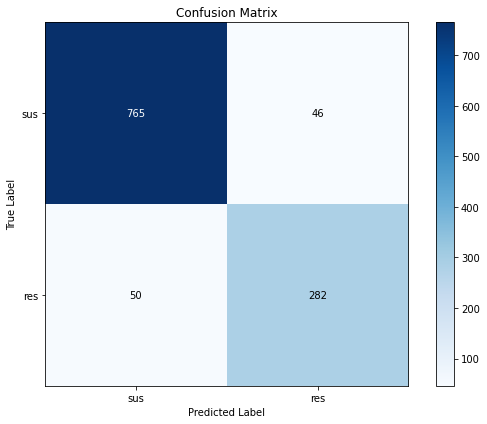

In [278]:

# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
clf.fit(train_data, train_target)

# Predict on the test data
test_predictions = clf.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_target, test_predictions)
print("Accuracy:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)

# Calculate sensitivity, specificity, and F1 score
tp = conf_matrix[1, 1]  # True Positive
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive
fn = conf_matrix[1, 0]  # False Negative

sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
f1 = f1_score(test_target, test_predictions)  # F1 Score
auc = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])  # AUC

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1)
print("AUC:", auc)

# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['sus', 'res'])
plt.yticks(tick_marks, ['sus', 'res'])

# Labeling the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Loop over data dimensions and create text annotations.
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

#### LOW qual removed

Accuracy: 0.90625
Sensitivity (Recall): 0.8449612403100775
Specificity: 0.9337979094076655
F1 Score: 0.8482490272373541
AUC: 0.9304250060773032


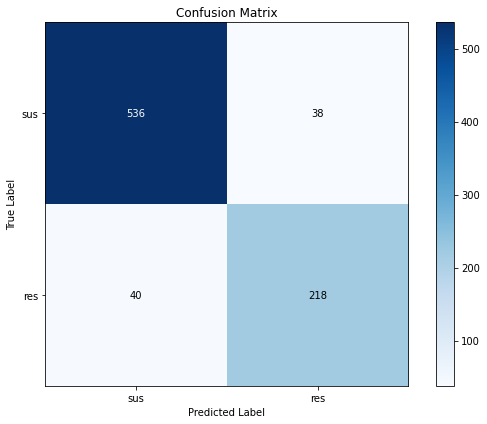

In [269]:

# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
clf.fit(train_data, train_target)

# Predict on the test data
test_predictions = clf.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_target, test_predictions)
print("Accuracy:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)

# Calculate sensitivity, specificity, and F1 score
tp = conf_matrix[1, 1]  # True Positive
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive
fn = conf_matrix[1, 0]  # False Negative

sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
f1 = f1_score(test_target, test_predictions)  # F1 Score
auc = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])  # AUC

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1)
print("AUC:", auc)


# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['sus', 'res'])
plt.yticks(tick_marks, ['sus', 'res'])

# Labeling the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Loop over data dimensions and create text annotations.
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

#### MID & LOW qual removed

Accuracy: 0.926490984743412
Sensitivity (Recall): 0.8709677419354839
Specificity: 0.9503968253968254
F1 Score: 0.877030162412993
AUC: 0.9441015653573258


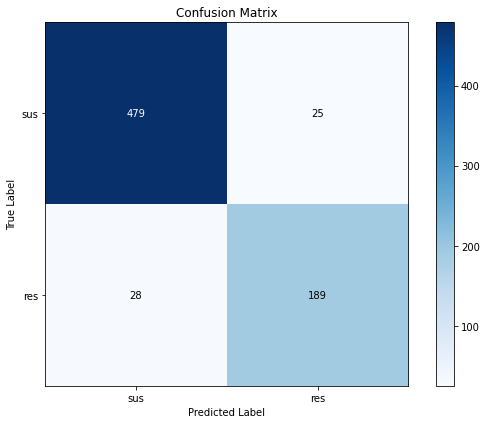

In [273]:

# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000, class_weight="balanced")
clf.fit(train_data, train_target)

# Predict on the test data
test_predictions = clf.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_target, test_predictions)
print("Accuracy:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)

# Calculate sensitivity, specificity, and F1 score
tp = conf_matrix[1, 1]  # True Positive
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive
fn = conf_matrix[1, 0]  # False Negative

sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
specificity = tn / (tn + fp)  # Specificity
f1 = f1_score(test_target, test_predictions)  # F1 Score
auc = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])  # AUC

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1)
print("AUC:", auc)


# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['sus', 'res'])
plt.yticks(tick_marks, ['sus', 'res'])

# Labeling the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Loop over data dimensions and create text annotations.
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

### Ending of the testing the effect of quality on model performance

In [178]:
# np.savetxt('data_new_emb/aa_data_train.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# # Save the remaining 10% of rows to another CSV file
# np.savetxt('data_new_emb/aa_data_test.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')

np.savetxt('data_new_emb/aa_data_train_gene.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_emb/aa_data_test_gene.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')
mic_aa = mic_aa[['EMB_MIC']].astype('float')

mic_aa.iloc[:int(mic_aa.shape[0]*0.9),:].to_csv('data_new_emb/mic_aa_train.csv', index=False)
mic_aa.iloc[int(mic_aa.shape[0]*0.9):,:].to_csv('data_new_emb/mic_aa_test.csv', index=False)

In [179]:
mic_aa['EMB_MIC'].value_counts()

EMB_MIC
1.000     3941
2.000     2935
4.000     1492
8.000     1366
0.500     1115
16.000     461
0.250       91
0.125       44
Name: count, dtype: int64

In [129]:
encoded_mic = []
for value in mic_aa['EMB_MIC'].to_list():
    if value <2 :
        encoded_mic.append(0)  # mic < 0.05
    elif value > 4:
        encoded_mic.append(2)
    else:# 0.05 <= mic < 0.12
        encoded_mic.append(1)  # 0.05 <= mic < 0.12

# mic_aa['EMB_MIC'] = encoded_mic


TypeError: '<' not supported between instances of 'str' and 'int'

In [57]:
mic_aa_cp = mic_aa.copy()
mic_aa_cp['EMB_MIC'] = encoded_mic
mic_aa_cp.iloc[:int(mic_aa_cp.shape[0]*0.9),:].to_csv('data_new_emb/mic_aa_train_hml.csv', index=False)
mic_aa_cp.iloc[int(mic_aa_cp.shape[0]*0.9):,:].to_csv('data_new_emb/mic_aa_test_hml.csv', index=False)

In [56]:
mic_aa_cp.shape

(11445, 1)

## ETH

In [25]:
df_eth = df[df['ETH_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
for i, row in df_eth.iterrows():
    x = 'ETH_MIC'
    if row[x] == '>8' :
        df_eth.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_eth.loc[i, f'{x}'] = '0.125'

/tmp/ipykernel_125163/3011970045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eth.loc[i, f'{x}'] = '16'
/tmp/ipykernel_125163/3011970045.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eth.loc[i, f'{x}'] = '0.125'


In [26]:
df_eth['ETH_MIC'] = df_eth['ETH_MIC'].astype('float')

variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_eth
overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
variants = variants[variants['drugs'].isin(['isoniazid,ethionamide', 'ethionamide', 'ethionamide,ethionamide'])]
variants = variants[variants['sample_id'].isin(overlap)]
variants['SNP'] = variants['gene'] + '-'+ variants['change']

def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
    # Create a dictionary from query_list and values_list for direct mapping
    query_dict = dict(zip(query_list, values_list))
    
    # Use list comprehension to build the output list directly
    output_list = [query_dict.get(snp, 0) for snp in set_list]
    
    return output_list

# Example usage
# set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
# query_list = ['SNP2', 'SNP4']
# values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
# output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
# print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

aa = []
all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
for x in tqdm(variants['sample_id'].unique()):
    aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
    # print('SNP')
    
aa_array = np.array(aa)
aa_array[aa_array < 0.8] = 0
aa_array[aa_array >= 0.8] = 1

mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
# mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
# mic_aa = mic_aa.sort_values('ENA_RUN')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'


np.savetxt('data_new_eth/aa_data_train_gene.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_eth/aa_data_test_gene.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')

# np.savetxt('data_new_eth/aa_data_train.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# # Save the remaining 10% of rows to another CSV file
# np.savetxt('data_new_eth/aa_data_test.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')
mic_aa = mic_aa[['ETH_MIC']].astype('float')

mic_aa.iloc[:int(mic_aa.shape[0]*0.9),:].to_csv('data_new_eth/mic_aa_train.csv', index=False)
mic_aa.iloc[int(mic_aa.shape[0]*0.9):,:].to_csv('data_new_eth/mic_aa_test.csv', index=False)

encoded_mic = []
for value in mic_aa['ETH_MIC']:
    if value <=2 :
        encoded_mic.append(0)  # mic < 0.05
    elif value >= 8:
        encoded_mic.append(2)
    else:# 0.05 <= mic < 0.12
        encoded_mic.append(1)  # 0.05 <= mic < 0.12

# mic_aa['ETH_MIC'] = encoded_mic
mic_aa_cp = mic_aa.copy()
mic_aa_cp['ETH_MIC'] = encoded_mic
mic_aa_cp.iloc[:int(mic_aa_cp.shape[0]*0.9),:].to_csv('data_new_eth/mic_aa_train_hml.csv', index=False)
mic_aa_cp.iloc[int(mic_aa_cp.shape[0]*0.9):,:].to_csv('data_new_eth/mic_aa_test_hml.csv', index=False)

/tmp/ipykernel_125163/3484501634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eth['ETH_MIC'] = df_eth['ETH_MIC'].astype('float')
100%|██████████| 2465/2465 [00:02<00:00, 879.00it/s]
/tmp/ipykernel_125163/3484501634.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_125163/3484501634.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## INH

In [27]:
df_inh = df[df['INH_MIC'].isin(['>1.6','1.6', '0.8', '0.4', '0.2', '0.1', '0.05', '<=0.025'])]
for i, row in df_inh.iterrows():
    x = 'INH_MIC'
    if row[x] == '>1.6' :
        df_inh.loc[i, f'{x}'] = '3.2'
    elif row[x] == '<=0.025':
        df_inh.loc[i, f'{x}'] = '0.0125'
        


/tmp/ipykernel_125163/3008021392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inh.loc[i, f'{x}'] = '0.0125'
/tmp/ipykernel_125163/3008021392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inh.loc[i, f'{x}'] = '3.2'


In [28]:
df_inh['INH_MIC'] = df_inh['INH_MIC'].astype('float')

variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_inh
overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
variants = variants[variants['drugs'].isin(['isoniazid,ethionamide', 'isoniazid', 'isoniazid,isoniazid'])]
variants = variants[variants['sample_id'].isin(overlap)]
variants['SNP'] = variants['gene'] + '-'+ variants['change']

def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
    # Create a dictionary from query_list and values_list for direct mapping
    query_dict = dict(zip(query_list, values_list))
    
    # Use list comprehension to build the output list directly
    output_list = [query_dict.get(snp, 0) for snp in set_list]
    
    return output_list

# Example usage
# set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
# query_list = ['SNP2', 'SNP4']
# values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
# output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
# print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

aa = []
all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
for x in tqdm(variants['sample_id'].unique()):
    aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
    # print('SNP')
    
aa_array = np.array(aa)
aa_array[aa_array < 0.8] = 0
aa_array[aa_array >= 0.8] = 1

mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
# mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
# mic_aa = mic_aa.sort_values('ENA_RUN')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'


np.savetxt('data_new_inh/aa_data_train_gene.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# Save the remaining 10% of rows to another CSV file
np.savetxt('data_new_inh/aa_data_test_gene.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')

# np.savetxt('data_new_inh/aa_data_train.csv', aa_array[:int(aa_array.shape[0]*0.9), :], delimiter=',', fmt='%s')
# # Save the remaining 10% of rows to another CSV file
# np.savetxt('data_new_inh/aa_data_test.csv', aa_array[int(aa_array.shape[0]*0.9):, :], delimiter=',', fmt='%s')
mic_aa = mic_aa[['INH_MIC']].astype('float')

mic_aa.iloc[:int(mic_aa.shape[0]*0.9),:].to_csv('data_new_inh/mic_aa_train.csv', index=False)
mic_aa.iloc[int(mic_aa.shape[0]*0.9):,:].to_csv('data_new_inh/mic_aa_test.csv', index=False)

encoded_mic = []
for value in mic_aa['INH_MIC']:
    if value <=0.1 :
        encoded_mic.append(0)  # mic < 0.05
    elif value >= 0.8:
        encoded_mic.append(2)
    else:# 0.05 <= mic < 0.12
        encoded_mic.append(1)  # 0.05 <= mic < 0.12

# mic_aa['INH_MIC'] = encoded_mic
mic_aa_cp = mic_aa.copy()
mic_aa_cp['INH_MIC'] = encoded_mic
mic_aa_cp.iloc[:int(mic_aa_cp.shape[0]*0.9),:].to_csv('data_new_inh/mic_aa_train_hml.csv', index=False)
mic_aa_cp.iloc[int(mic_aa_cp.shape[0]*0.9):,:].to_csv('data_new_inh/mic_aa_test_hml.csv', index=False)

/tmp/ipykernel_125163/2080128498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inh['INH_MIC'] = df_inh['INH_MIC'].astype('float')
100%|██████████| 3959/3959 [00:05<00:00, 738.81it/s]
/tmp/ipykernel_125163/2080128498.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_125163/2080128498.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

# Previous

In [4]:
ar = df[['AMI_MIC', 'BDQ_MIC','CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC', 'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']].values

list_2d = [element for row in ar for element in row]
print(np.unique(list_2d))
print(value_counts_list(list_2d))

['0.015' '0.03' '0.05' '0.06' '0.1' '0.12' '0.2' '0.25' '0.4' '0.5' '0.8'
 '1' '1.6' '12.8' '16' '2' '3.2' '32' '4' '6.4' '8' '<=0.008' '<=0.015'
 '<=0.025' '<=0.03' '<=0.06' '<=0.12' '<=0.25' '<=1' '>0.5' '>1' '>1.6'
 '>12.8' '>16' '>2' '>32' '>4' '>8' 'nan']
{'0.5': 21599, '<=0.06': 14544, '2': 13432, '0.25': 13103, '1': 12719, '0.12': 9420, '0.06': 8132, '<=0.25': 7382, '<=0.015': 6288, '4': 5803, '0.03': 5529, '>8': 3931, '<=1': 3540, '0.05': 3426, '8': 3398, '<=0.008': 3309, '>2': 3157, '>4': 2856, '0.015': 2840, '<=0.025': 2458, nan: 2356, '<=0.03': 2237, '>1.6': 1647, '1.6': 1426, '>16': 1026, '3.2': 890, '<=0.12': 435, '16': 423, '6.4': 373, '0.2': 366, '0.8': 349, '0.4': 307, '>12.8': 294, '0.1': 275, '12.8': 255, '32': 80, '>1': 56, '>0.5': 30, '>32': 14}


['<=0.008', '<=0.015', '0.015', '<=0.025', '0.03', '<=0.03', '0.05', '0.06', '<=0.06', '0.1', '0.12', '<=0.12', '0.2', '0.25', '<=0.25', '0.4', '<=1', '>0.5', '>1', '>1.6', '0.5', '0.8', '>4', '1', '>8', '1.6', '2', '3.2', '4', '6.4', '8', '12.8', '16', '>12.8', '>16', '>32', '>2', '32']


In [5]:
# # below code removes values that are the edge cases of the MIC values
# for i, row in df.iterrows():
#     for x in ['AMI_MIC', 'BDQ_MIC', 'CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC', 'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']:
#         if row[x] in ['<=0.008', '<=0.015', '<=0.025', '<=0.03', '<=0.06','<=0.12','<=0.25']:
#             df.loc[i, f'{x}'] = '<=0.25'
#         elif row[x] in ['>8', '12.8', '>12.8', '16', '>16', '32', '>32' ]:
#             df.loc[i, f'{x}'] = '>32'
#         elif row[x] in ['>0.5','<=1','>1','>1.6','>2','>4']:
#             df.loc[i, f'{x}'] = float('nan')

In [6]:
df.columns

Index(['UNIQUEID', 'AMI_BINARY_PHENOTYPE', 'BDQ_BINARY_PHENOTYPE',
       'CFZ_BINARY_PHENOTYPE', 'DLM_BINARY_PHENOTYPE', 'EMB_BINARY_PHENOTYPE',
       'ETH_BINARY_PHENOTYPE', 'INH_BINARY_PHENOTYPE', 'KAN_BINARY_PHENOTYPE',
       'LEV_BINARY_PHENOTYPE', 'LZD_BINARY_PHENOTYPE', 'MXF_BINARY_PHENOTYPE',
       'RIF_BINARY_PHENOTYPE', 'RFB_BINARY_PHENOTYPE', 'AMI_MIC', 'BDQ_MIC',
       'CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC',
       'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC',
       'AMI_PHENOTYPE_QUALITY', 'BDQ_PHENOTYPE_QUALITY',
       'CFZ_PHENOTYPE_QUALITY', 'EMB_PHENOTYPE_QUALITY',
       'ETH_PHENOTYPE_QUALITY', 'INH_PHENOTYPE_QUALITY',
       'KAN_PHENOTYPE_QUALITY', 'LEV_PHENOTYPE_QUALITY',
       'LZD_PHENOTYPE_QUALITY', 'MXF_PHENOTYPE_QUALITY',
       'RIF_PHENOTYPE_QUALITY', 'RFB_PHENOTYPE_QUALITY', 'ENA_SAMPLE', 'VCF',
       'REGENOTYPED_VCF', 'wgs_id'],
      dtype='object')

In [19]:
for x in ['AMI_MIC', 'BDQ_MIC',
       'CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC',
       'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']:
    print(x)
    # print(df[x].value_counts())
    print(df[x].unique())

AMI_MIC
['<=0.25' '0.5' '1' '>8' '4' '2' '8' nan '>16' '16']
BDQ_MIC
[nan '0.06' '0.03' '0.25' '<=0.015' '0.5' '0.12' '2' '>2' '0.015'
 '<=0.008' '>1' '1']
CFZ_MIC
['<=0.06' '0.12' '0.25' '0.5' '2' '1' '4' nan '>4' '<=0.03' '0.06' '>2']
DLM_MIC
['<=0.015' nan '0.03' '0.06' '0.12' '>1' '0.5' '0.25' '1' '<=0.008'
 '0.015' '>0.5']
EMB_MIC
['1' '2' '0.5' '4' '>8' '8' nan '0.25' '<=0.06' '0.12' '16' '>32' '32'
 '<=0.25']
ETH_MIC
['2' '1' '4' '>8' '0.5' '8' '<=0.25' nan]
INH_MIC
['0.05' '<=0.025' '0.2' '0.1' '>1.6' '1.6' nan '0.8' '0.4' '3.2' '12.8'
 '>12.8' '6.4']
KAN_MIC
['2' '<=1' '>16' '16' '4' nan '8']
LEV_MIC
['0.25' '1' '0.5' '<=0.12' '2' '8' '>8' '4' nan]
LZD_MIC
['0.25' '0.5' '1' '2' '>2' '0.12' nan '<=0.03' '0.06' '<=0.06' '4' '>4']
MXF_MIC
['0.25' '0.5' '0.12' '2' '4' '1' '>4' '<=0.06' nan]
RIF_MIC
['<=0.06' '0.12' '>4' '4' '2' '0.25' '0.5' nan '1' '>8' '0.06' '<=0.03'
 '8']
RFB_MIC
['<=0.06' '>2' '0.12' '0.5' '2' '0.25' '1' nan]


In [20]:
df_ori = df.copy()

In [23]:
df_ori['RIF_MIC'].value_counts()

<=0.06    2317
>4        2243
0.12      2105
>8        1771
0.06      1326
<=0.03     753
0.25       723
8          229
0.5        188
4          169
2          151
1          120
Name: RIF_MIC, dtype: int64

In [25]:
df['RIF_MIC'].value_counts()

8        2472
0.03     2317
0.12     2105
16       1771
0.06     1326
0.015     753
0.25      723
0.5       188
4         169
2         151
1         120
Name: RIF_MIC, dtype: int64

In [22]:
for x in ['AMI_MIC', 'BDQ_MIC',
       'CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC',
       'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']:
    print(x)
    # print(df[x].value_counts())
    print(df[x].unique())

AMI_MIC
['0.125' '0.5' '1' '16' '4' '2' '8' nan '32']
BDQ_MIC
[nan '0.06' '0.03' '0.25' '0.0075' '0.5' '0.12' '2' '4' '0.015' '0.004'
 '1']
CFZ_MIC
['0.03' '0.12' '0.25' '0.5' '2' '1' '4' nan '8' '0.015' '0.06']
DLM_MIC
['0.0075' nan '0.03' '0.06' '0.12' '2' '0.5' '0.25' '1' '0.004' '0.015'
 '1.0']
EMB_MIC
['1' '2' '0.5' '4' '16' '8' nan '0.25' '0.03' '0.12' '64' '32' '0.125']
ETH_MIC
['2' '1' '4' '16' '0.5' '8' '0.125' nan]
INH_MIC
['0.05' '0.01125' '0.2' '0.1' '3.2' '1.6' nan '0.8' '0.4' '12.8' '25.6'
 '6.4']
KAN_MIC
['2' '0.5' '32' '16' '4' nan '8']
LEV_MIC
['0.25' '1' '0.5' '0.06' '2' '8' '16' '4' nan]
LZD_MIC
['0.25' '0.5' '1' '2' '4' '0.12' nan '0.15' '0.06' '0.03' '8']
MXF_MIC
['0.25' '0.5' '0.12' '2' '4' '1' '8' '0.03' nan]
RIF_MIC
['0.03' '0.12' '8' '4' '2' '0.25' '0.5' nan '1' '16' '0.06' '0.015']
RFB_MIC
['0.03' '4' '0.12' '0.5' '2' '0.25' '1' nan]


In [21]:
# below code removes values that are the edge cases of the MIC values

for i, row in df.iterrows():
    x = 'AMI_MIC'
    if row[x] == '<=0.25' :
        df.loc[i, f'{x}'] = '0.125'
    elif row[x] == '>16':
        df.loc[i, f'{x}'] = '32'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'    

    x = 'BDQ_MIC'
    if row[x] == '<=0.015' :
        df.loc[i, f'{x}'] = '0.0075'
    elif row[x] == '<=0.008' :
        df.loc[i, f'{x}'] = '0.004'
    elif row[x] == '>1':
        df.loc[i, f'{x}'] = '2'  
    elif row[x] == '>2':
        df.loc[i, f'{x}'] = '4'
        
    x = 'CFZ_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '<=0.03':
        df.loc[i, f'{x}'] = '0.015'
    elif row[x] == '>2': #! there is middle value between two ranges
        df.loc[i, f'{x}'] = '4'
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'
        
    x = 'DLM_MIC'
    if row[x] == '<=0.015' :
        df.loc[i, f'{x}'] = '0.0075'
    elif row[x] == '<=0.008':
        df.loc[i, f'{x}'] = '0.004'
    elif row[x] == '>1':
        df.loc[i, f'{x}'] = '2' #! there is middle value between two ranges, should i turn these range values in the middle into nan
    elif row[x] == '>0.5':
        df.loc[i, f'{x}'] = '1.0'

    
    x = 'EMB_MIC'
    if row[x] == '<=0.25' :
        df.loc[i, f'{x}'] = '0.125'
    elif row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'
    elif row[x] == '>32':
        df.loc[i, f'{x}'] = '64'     
           
    x = 'ETH_MIC'
    if row[x] == '<=0.25' :
        df.loc[i, f'{x}'] = '0.125'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'
        
    x = 'INH_MIC'
    if row[x] == '<=0.025' :
        df.loc[i, f'{x}'] = '0.01125'
    elif row[x] == '>12.8':
        df.loc[i, f'{x}'] = '25.6'
    elif row[x] == '>1.6':
        df.loc[i, f'{x}'] = '3.2'         
        
    x = 'KAN_MIC'
    if row[x] == '<=1' :
        df.loc[i, f'{x}'] = '0.5'
    elif row[x] == '>16':
        df.loc[i, f'{x}'] = '32'   

    x = 'LEV_MIC'
    if row[x] == '<=0.12' :
        df.loc[i, f'{x}'] = '0.06'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'

    x = 'LZD_MIC'
    if row[x] == '<=0.03' :
        df.loc[i, f'{x}'] = '0.15'
    elif row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>2':
        df.loc[i, f'{x}'] = '4'
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'                                                                                     

    x = 'MXF_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'    
    
    x = 'RIF_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '<=0.03':
        df.loc[i, f'{x}'] = '0.015'    
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'   
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'
        
        
    x = 'RFB_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>2':
        df.loc[i, f'{x}'] = '4'    

In [20]:
# below code removes values that are the edge cases of the MIC values

for i, row in df.iterrows():
    x = 'AMI_MIC'
    if row[x] == '<=0.25' :
        df.loc[i, f'{x}'] = '0.125'
    elif row[x] == '>16':
        df.loc[i, f'{x}'] = '32'
    # elif row[x] == '>8':
        # df.loc[i, f'{x}'] = '16'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '32'    

    x = 'BDQ_MIC'
    if row[x] == '<=0.015' :
        df.loc[i, f'{x}'] = '0.0075'
    elif row[x] == '<=0.008' :
        df.loc[i, f'{x}'] = '0.004'
    # elif row[x] == '>1':
        # df.loc[i, f'{x}'] = '2'  
    elif row[x] == '>1':
        df.loc[i, f'{x}'] = '4'    
    elif row[x] == '>2':
        df.loc[i, f'{x}'] = '4'
        
    x = 'CFZ_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '<=0.03':
        df.loc[i, f'{x}'] = '0.015'
    # elif row[x] == '>2': #! there is middle value between two ranges
    #     df.loc[i, f'{x}'] = '4'
    elif row[x] == '>2': #! there is middle value between two ranges
        df.loc[i, f'{x}'] = '8'
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'
        
    x = 'DLM_MIC'
    if row[x] == '<=0.015' :
        df.loc[i, f'{x}'] = '0.0075'
    elif row[x] == '<=0.008':
        df.loc[i, f'{x}'] = '0.004'
    elif row[x] == '>1':
        df.loc[i, f'{x}'] = '2' #! there is middle value between two ranges, should i turn these range values in the middle into nan
    # elif row[x] == '>0.5':
    #     df.loc[i, f'{x}'] = '1.0'
    elif row[x] == '>0.5':
        df.loc[i, f'{x}'] = '2'
    
    x = 'EMB_MIC'
    if row[x] == '<=0.25' :
        df.loc[i, f'{x}'] = '0.125'
    elif row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'
    elif row[x] == '>32':
        df.loc[i, f'{x}'] = '64'     
           
    x = 'ETH_MIC'
    if row[x] == '<=0.25' :
        df.loc[i, f'{x}'] = '0.125'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'
        
    x = 'INH_MIC'
    if row[x] == '<=0.025' :
        df.loc[i, f'{x}'] = '0.01125'
    elif row[x] == '>12.8':
        df.loc[i, f'{x}'] = '25.6'
    elif row[x] == '>1.6':
        df.loc[i, f'{x}'] = '3.2'         
        
    x = 'KAN_MIC'
    if row[x] == '<=1' :
        df.loc[i, f'{x}'] = '0.5'
    elif row[x] == '>16':
        df.loc[i, f'{x}'] = '32'   

    x = 'LEV_MIC'
    if row[x] == '<=0.12' :
        df.loc[i, f'{x}'] = '0.06'
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'

    x = 'LZD_MIC'
    if row[x] == '<=0.03' :
        df.loc[i, f'{x}'] = '0.15'
    elif row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>2':
        df.loc[i, f'{x}'] = '4'
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'                                                                                     

    x = 'MXF_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'    
    
    x = 'RIF_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '<=0.03':
        df.loc[i, f'{x}'] = '0.015'    
    elif row[x] == '>8':
        df.loc[i, f'{x}'] = '16'   
    elif row[x] == '>4':
        df.loc[i, f'{x}'] = '8'
        
        
    x = 'RFB_MIC'
    if row[x] == '<=0.06' :
        df.loc[i, f'{x}'] = '0.03'
    elif row[x] == '>2':
        df.loc[i, f'{x}'] = '4'    

In [23]:
for x in ['AMI_MIC', 'BDQ_MIC',
       'CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC',
       'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']:
    print(df[x].unique())
# df['RIF_MIC'].unique()

['0.125' '0.5' '1' '16' '4' '2' '8' nan '32']
[nan '0.06' '0.03' '0.25' '0.0075' '0.5' '0.12' '2' '4' '0.015' '0.004'
 '1']
['0.03' '0.12' '0.25' '0.5' '2' '1' '4' nan '8' '0.015' '0.06']
['0.0075' nan '0.03' '0.06' '0.12' '2' '0.5' '0.25' '1' '0.004' '0.015'
 '1.0']
['1' '2' '0.5' '4' '16' '8' nan '0.25' '0.03' '0.12' '64' '32' '0.125']
['2' '1' '4' '16' '0.5' '8' '0.125' nan]
['0.05' '0.01125' '0.2' '0.1' '3.2' '1.6' nan '0.8' '0.4' '12.8' '25.6'
 '6.4']
['2' '0.5' '32' '16' '4' nan '8']
['0.25' '1' '0.5' '0.06' '2' '8' '16' '4' nan]
['0.25' '0.5' '1' '2' '4' '0.12' nan '0.15' '0.06' '0.03' '8']
['0.25' '0.5' '0.12' '2' '4' '1' '8' '0.03' nan]
['0.03' '0.12' '8' '4' '2' '0.25' '0.5' nan '1' '16' '0.06' '0.015']
['0.03' '4' '0.12' '0.5' '2' '0.25' '1' nan]


In [24]:
ar = df[['AMI_MIC', 'BDQ_MIC','CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC', 'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']].values

list_2d = [element for row in ar for element in row]
print(value_counts_list(list_2d))

{'0.5': 25139, '0.03': 20073, '2': 13488, '0.25': 13103, '1': 12719, '0.12': 9420, '4': 8960, '0.06': 8567, '0.125': 7382, '0.0075': 6288, '8': 6254, '0.015': 5001, '16': 4354, '0.05': 3426, '0.004': 3309, '3.2': 2537, '0.01125': 2458, nan: 2356, '1.6': 1426, '32': 1106, '6.4': 373, '0.2': 366, '0.8': 349, '0.4': 307, '25.6': 294, '0.1': 275, '12.8': 255, '0.15': 76, '1.0': 30, '64': 14}


In [25]:
drug_names = {
    'AMI': 'Amikacin',
    'BDQ': 'Bedaquiline',
    'CFZ': 'Clofazimine',
    'EMB': 'Ethambutol',
    'ETH': 'Ethionamide',
    'INH': 'Isoniazid', # the critical concentration would be 0.0312 mg/liter for low-level resistance and 0.125 mg/liter for high-level resistance
    'KAN': 'Kanamycin',
    'LEV': 'Levofloxacin',
    'LZD': 'Linezolid',
    'MXF': 'Moxifloxacin',
    'RIF': 'Rifampicin',
    'RFB': 'Rifabutin'
}

In [12]:
# # below code removes all MIC values with low quality
# for i, row in df.iterrows():
#     for x in ['AMI', 'BDQ', 'CFZ', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']:
#         if row[f'{x}_PHENOTYPE_QUALITY'] == 'LOW':
#             df.loc[i, f'{x}_MIC'] = float('nan')
#             # print(df.loc[i, f'{x}_MIC'])

### res data output

In [27]:
# check if the range values are removed
for x in ['AMI', 'BDQ', 'CFZ', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']:
    print(f'{x}_MIC')
    print(df[f'{x}_MIC'].unique())

AMI_MIC
['0.25' '0.5' '1' '8' '4' '2' nan '16']
BDQ_MIC
[nan '0.06' '0.03' '0.25' '0.005' '0.5' '0.12' '2' '0.015' '0.008' '1']
CFZ_MIC
['0.06' '0.12' '0.25' '0.5' '2' '1' '4' nan '0.03']
EMB_MIC
['1' '2' '0.5' '4' '8' nan '0.25' '0.06' '0.12' '16' '32']
ETH_MIC
['2' '1' '4' '8' '0.5' '0.25' nan]
INH_MIC
['0.05' '0.025' '0.2' '0.1' '1.6' nan '0.8' '0.4' '3.2' '12.8' '6.4']
KAN_MIC
['2' '1' '16' '4' nan '8']
LEV_MIC
['0.25' '1' '0.5' '0.12' '2' '8' '4' nan]
LZD_MIC
['0.25' '0.5' '1' '2' '0.12' nan '0.03' '0.06' '4' 5]
MXF_MIC
['0.25' '0.5' '0.12' '2' '4' '1' 5 '0.06' nan]
RIF_MIC
['0.06' '0.12' '4' '2' '0.25' '0.5' nan '1' '8' '0.03']
RFB_MIC
['0.06' '3' '0.12' '0.5' '2' '0.25' '1' nan]


In [27]:
df.sort_values(by=['wgs_id'], inplace=True)
df.to_csv('data1/CRyPTIC_reuse_table_20221019_cleaned.csv', index=False)

In [28]:
mic = df.iloc[:,14:27].astype('float')

In [29]:
mic

,AMI_MIC,BDQ_MIC,CFZ_MIC,DLM_MIC,EMB_MIC,ETH_MIC,INH_MIC,KAN_MIC,LEV_MIC,LZD_MIC,MXF_MIC,RIF_MIC,RFB_MIC
5839,0.500,0.060,0.120,0.0300,2.0,2.0,0.05,2.0,0.50,0.50,0.50,0.12,0.03
5840,0.500,0.060,0.030,0.0075,2.0,1.0,0.05,2.0,0.50,0.50,0.25,0.12,0.03
5841,0.125,0.060,0.030,0.0075,2.0,2.0,0.05,2.0,0.25,0.50,0.25,0.03,0.03
5842,0.500,0.060,0.120,0.0075,1.0,NaN,0.05,4.0,1.00,1.00,0.50,0.12,0.03
5843,0.125,0.060,0.120,0.0075,2.0,1.0,0.10,2.0,0.25,0.50,0.25,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11394,0.125,0.015,0.015,0.0040,8.0,16.0,25.60,2.0,2.00,0.25,0.50,16.00,4.00
11395,0.125,0.030,0.060,0.0040,4.0,4.0,6.40,2.0,8.00,0.25,8.00,16.00,4.00
11397,1.000,0.030,0.060,0.0150,4.0,8.0,12.80,16.0,0.50,0.50,0.25,16.00,4.00
11398,0.500,0.015,0.060,0.0150,0.5,8.0,0.20,2.0,0.25,0.12,0.12,0.06,4.00


In [34]:
mic.shape

(12285, 13)

In [31]:
mic.iloc[:int(mic.shape[0]*0.9),:].shape

(11056, 13)

In [32]:
mic.iloc[:int(mic.shape[0]*0.9),:].to_csv('data1/res_train.csv', index=False)
mic.iloc[int(mic.shape[0]*0.9):,:].to_csv('data1/res_test.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'mic' is your DataFrame
# Shuffle the indices
indices = np.arange(mic.shape[0])
np.random.shuffle(indices)

# Calculate the split index
split_idx = int(len(indices) * 0.9)

# Split the indices into training and testing parts
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

# Use iloc to create training and testing sets based on the shuffled indices
train_set = mic.iloc[train_indices]
test_set = mic.iloc[test_indices]

# Save the sets to CSV files
train_set.to_csv('data1/res_train.csv', index=False)
test_set.to_csv('data1/res_test.csv', index=False)


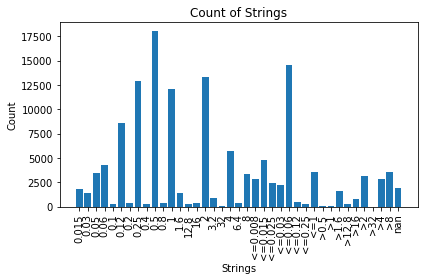

In [147]:
import plotly.graph_objects as go
from collections import Counter

unique_strings, counts = np.unique(ar_list, return_counts=True)
plt.bar(unique_strings, counts)
plt.xlabel("Strings")
plt.ylabel("Count")
plt.title("Count of Strings")
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()
plt.show()

In [13]:
np.unique(df[['CFZ_MIC', 'DLM_MIC', 'EMB_MIC', 'ETH_MIC', 'INH_MIC', 'KAN_MIC',
       'LEV_MIC', 'LZD_MIC', 'MXF_MIC', 'RIF_MIC', 'RFB_MIC']].values)

TypeError: '<' not supported between instances of 'float' and 'str'

In [24]:
# File path to save the output
file_path = "sample_list.txt"

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each string from the list to a new line in the file
    for string in df['wgs_id'].tolist():
        file.write(string + '\n')


In [ ]:
for x in tqdm(df['wgs_id']):
    print(x)
    # break

In [ ]:
import subprocess
for x in df['wgs_id']:
    fasta_file = "/mnt/storageG1/lwang/Projects/tb_dr_MIC/MTB-h37rv_asm19595v2-eg18.fa"
    vcf_file = f"/mnt/storage7/jody/tb_ena/per_sample/{x}.freebayes.vcf.gz"
    output_file = f"/mnt/storageG1/lwang/Projects/tb_dr_MIC/fasta/{x}.fa"
    command = ["bcftools", "consensus", "-f", fasta_file, vcf_file, "-o", output_file]
    # Run the command using subprocess
    subprocess.run(command)
    
    #Run the command using subprocess
    # subprocess.run(
    #     f"bcftools consensus -f", fasta_file, vcf_file, "-o", output_file,
    #     shell=False,
    # )

# Classification target

In [5]:
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_train.csv')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_test.csv')

In [10]:
np.unique(train_target['RIF_MIC'].values)

array([1.5e-02, 3.0e-02, 6.0e-02, 1.2e-01, 2.5e-01, 5.0e-01, 1.0e+00,
       2.0e+00, 4.0e+00, 8.0e+00, 1.6e+01,     nan])

# Generating Sequence data

In [17]:
import os

def get_filenames_without_fa_extension(directory):
    # List all files in the directory
    filenames = os.listdir(directory)
    
    # Remove '.fa' extension from file names
    filenames_without_fa = [filename.replace('.fa', '') for filename in filenames]
    
    return filenames_without_fa

# Specify the directory to search
directory_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/fasta/'

# Get the processed list of file names
file_names = get_filenames_without_fa_extension(directory_path)
print(len(file_names))



12055


In [168]:
df = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/CRyPTIC_reuse_table_20231208.csv')

# df = df[df['wgs_id'].isin(file_names)]

In [32]:
df['wgs_id'] = pd.Categorical(df['wgs_id'], categories=file_names, ordered=True)
df_sorted = df.sort_values('wgs_id')



In [38]:
df_sorted['wgs_id'].tolist() == file_names

True

In [45]:
df.to_csv('data1/CRyPTIC_reuse_table_20221019_cleaned_ordered.csv')

In [47]:
from Bio import SeqIO
import csv
from Bio.SeqUtils import six_frame_translations

df_seq = pd.DataFrame(columns=['wgs_id','acpM-kasA', 'ethAR', 'aftB-ubiA', 'tlyA', 'embCAB', 'gid', 'panD',
       'rpoBC', 'rpsA', 'katG', 'rpsL', 'pncA', 'clpC', 'gyrBA',
       'oxyR-ahpC', 'eis', 'rrs-rrl', 'fabG1-inhA'])

for x in tqdm(df_sorted['wgs_id']):
    fasta_file = f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/fasta/{x}.fa'
    bed_file = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/gene_ordered.csv'
    # output_file = 'output.csv'

    sequences = [x]
    df_gene = pd.read_csv('gene_ordered.csv')
    for i, row in df_gene.iterrows():
        # print(row)
        locus, start, end = row[0], int(row[1]), int(row[2])
        
        # Extract the sequence based on the range
        with open(fasta_file, 'r') as fasta:
            record_dict = SeqIO.to_dict(SeqIO.parse(fasta, 'fasta'))
            sequence = record_dict['Chromosome'].seq[start:end]
            sequences.append(str(sequence))
            
    df_seq.loc[df_seq.shape[0]] = sequences

100%|██████████| 12055/12055 [1:43:43<00:00,  1.94it/s]


In [105]:
# df_seq.sort_values(by=['wgs_id'], inplace=True)

In [48]:
df_seq.to_csv('data1/gene_seq.csv', index=False)
df_seq = pd.read_csv('data1/gene_seq.csv')
df_seq.iloc[:int(df_seq.shape[0]*0.9),:].to_csv('data1/gene_seq_train.csv', index=False)
df_seq.iloc[int(df_seq.shape[0]*0.9):,:].to_csv('data1/gene_seq_test.csv', index=False)

In [49]:
df_seq.to_csv('data0/gene_seq.csv', index=False)
df_seq = pd.read_csv('data0/gene_seq.csv')
df_seq.iloc[:int(df_seq.shape[0]*0.9),:].to_csv('data0/gene_seq_train.csv', index=False)
df_seq.iloc[int(df_seq.shape[0]*0.9):,:].to_csv('data0/gene_seq_test.csv', index=False)

In [52]:
df

,UNIQUEID,AMI_BINARY_PHENOTYPE,BDQ_BINARY_PHENOTYPE,CFZ_BINARY_PHENOTYPE,DLM_BINARY_PHENOTYPE,EMB_BINARY_PHENOTYPE,ETH_BINARY_PHENOTYPE,INH_BINARY_PHENOTYPE,KAN_BINARY_PHENOTYPE,LEV_BINARY_PHENOTYPE,...,KAN_PHENOTYPE_QUALITY,LEV_PHENOTYPE_QUALITY,LZD_PHENOTYPE_QUALITY,MXF_PHENOTYPE_QUALITY,RIF_PHENOTYPE_QUALITY,RFB_PHENOTYPE_QUALITY,ENA_SAMPLE,VCF,REGENOTYPED_VCF,wgs_id
0,site.05.subj.PTAN-0001.lab.TAN-001.iso.1,S,S,S,S,S,S,S,S,S,...,HIGH,LOW,HIGH,HIGH,HIGH,HIGH,ERS1987021,00/00/04/90/490/site.05.iso.1.subject.PTAN-000...,00/00/04/90/490/site.05.iso.1.subject.PTAN-000...,ERR2184202
1,site.05.subj.PTAN-0002.lab.TAN-004.iso.1,S,S,S,S,S,S,S,S,S,...,HIGH,HIGH,LOW,LOW,LOW,HIGH,ERS1987022,00/00/04/91/491/site.05.iso.1.subject.PTAN-000...,00/00/04/91/491/site.05.iso.1.subject.PTAN-000...,ERR2184203
2,site.05.subj.PTAN-0003.lab.TAN-006.iso.1,S,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,LOW,HIGH,HIGH,ERS1987023,00/00/04/92/492/site.05.iso.1.subject.PTAN-000...,00/00/04/92/492/site.05.iso.1.subject.PTAN-000...,ERR2184204
3,site.05.subj.PTAN-0004.lab.TAN-007.iso.1,S,S,S,S,S,NaN,S,S,S,...,HIGH,HIGH,LOW,HIGH,HIGH,HIGH,ERS1987024,00/00/04/93/493/site.05.iso.1.subject.PTAN-000...,00/00/04/93/493/site.05.iso.1.subject.PTAN-000...,ERR2184205
4,site.05.subj.PTAN-0005.lab.TAN-010.iso.1,S,S,S,S,S,S,S,S,S,...,HIGH,HIGH,LOW,HIGH,HIGH,HIGH,ERS1987025,00/00/04/94/494/site.05.iso.1.subject.PTAN-000...,00/00/04/94/494/site.05.iso.1.subject.PTAN-000...,ERR2184206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12121,site.10.subj.YA00121669.lab.YA00121669.iso.1,S,S,R,S,S,S,S,R,S,...,LOW,LOW,LOW,LOW,LOW,HIGH,ERS6403690,00/02/96/81/29681/site.10.iso.1.subject.YA0012...,00/02/96/81/29681/site.10.iso.1.subject.YA0012...,ERR8976118
12122,site.10.subj.YA00122414.lab.YA00122414.iso.1,S,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,LOW,HIGH,HIGH,ERS6403691,00/02/96/82/29682/site.10.iso.1.subject.YA0012...,00/02/96/82/29682/site.10.iso.1.subject.YA0012...,ERR8976119
12123,site.10.subj.YA00122415.lab.YA00122415.iso.1,S,S,S,S,S,S,S,S,S,...,LOW,LOW,LOW,LOW,HIGH,HIGH,ERS6403692,00/02/96/83/29683/site.10.iso.1.subject.YA0012...,00/02/96/83/29683/site.10.iso.1.subject.YA0012...,ERR8976120
12125,site.10.subj.YA00129008.lab.YA00129008.iso.1,S,S,S,S,S,S,R,S,S,...,LOW,LOW,LOW,LOW,LOW,HIGH,ERS6403694,00/02/96/85/29685/site.10.iso.1.subject.YA0012...,00/02/96/85/29685/site.10.iso.1.subject.YA0012...,ERR8976122


# generating corresponding MIC data for the seq data as somehow not all data have fasta

In [55]:
df_sorted['wgs_id'].tolist() == df_seq['wgs_id'].tolist()


True

In [58]:
mic = df_sorted.iloc[:,14:27].astype('float')
mic.iloc[:int(mic.shape[0]*0.9),:].to_csv('data1/res_train.csv', index=False)
mic.iloc[int(mic.shape[0]*0.9):,:].to_csv('data1/res_test.csv', index=False)

### seq data output

In [60]:
mic

,AMI_MIC,BDQ_MIC,CFZ_MIC,DLM_MIC,EMB_MIC,ETH_MIC,INH_MIC,KAN_MIC,LEV_MIC,LZD_MIC,MXF_MIC,RIF_MIC,RFB_MIC
7627,0.125,0.030,0.030,0.0075,1.0,1.000,0.05000,4.0,0.25,0.50,0.25,0.120,0.03
9758,0.125,0.030,0.030,0.0075,2.0,2.000,1.60000,0.5,4.00,0.25,0.50,2.000,0.03
10564,1.000,0.030,0.060,0.0040,16.0,16.000,12.80000,16.0,16.00,0.25,8.00,16.000,4.00
5667,0.125,0.004,0.015,0.0040,8.0,0.500,1.60000,2.0,0.50,0.25,0.12,8.000,0.12
4745,0.125,0.004,0.015,0.0040,1.0,0.125,NaN,0.5,0.25,0.12,0.03,0.120,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,0.125,0.060,0.250,0.0075,2.0,1.000,3.20000,2.0,0.50,1.00,0.25,8.000,0.25
9502,0.125,0.030,0.060,0.0040,1.0,2.000,0.05000,2.0,0.25,0.50,0.25,0.120,0.03
4755,0.125,0.015,0.015,0.0150,2.0,0.500,0.01125,2.0,0.25,0.50,0.25,0.015,0.03
14,0.125,0.060,0.030,0.0075,1.0,2.000,0.05000,2.0,0.25,1.00,0.25,0.030,0.03
